In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import BisectingKMeans, Birch


In [3]:
df = pd.read_excel("!01_02-18_VSE.xlsx") # считываем данные
df.to_csv("data.csv") # сохраняем в csv, чтобы не грузить данные по несколько минут

In [2]:
df = pd.read_csv("data.csv", low_memory=False).drop(["Unnamed: 0"], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693710 entries, 0 to 693709
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Дата                        693710 non-null  object 
 1   ДеньНедели                  693710 non-null  object 
 2   Час                         693710 non-null  int64  
 3   ДатаДоставки                693070 non-null  object 
 4   НомерЗаказаНаСайте          693710 non-null  object 
 5   Кол-во чеков                693710 non-null  int64  
 6   НовыйСтатус                 693710 non-null  object 
 7   СуммаЗаказаНаСайте          693710 non-null  float64
 8   СуммаДокумента              693710 non-null  float64
 9   МетодДоставки               693634 non-null  object 
 10  ФормаОплаты                 693631 non-null  object 
 11  Регион                      689119 non-null  object 
 12  Группа2                     572350 non-null  object 
 13  Группа3       

In [5]:
(df.isna().sum()/len(df)*100).sort_values(ascending=False) # смотрим распределение nan по столбцам

МагазинЗаказа                 99.349584
ПричинаОтмены                 91.979213
ПВЗ_код                       23.320119
ЦенаЗакупки                   21.547332
Группа4                       20.387193
Группа3                       17.494342
Группа2                       17.494342
ТипТовара                     17.494342
ЭлектроннаяПочта_new           1.787923
Регион                         0.661804
ДатаДоставки                   0.092258
Клиент                         0.016722
ФормаОплаты                    0.011388
МетодДоставки                  0.010956
Маржа                          0.000000
Гео                            0.000000
СуммаУслуг                     0.000000
СуммаДоставки                  0.000000
Дата                           0.000000
НомерСтроки                    0.000000
КоличествоПроданоКлиенту       0.000000
ДатаЗаказаНаСайте              0.000000
Телефон_new                    0.000000
ID_SKU                         0.000000
ГородМагазина                  0.000000


In [6]:
# Выбираем столбцы с категориальными данными
cat_columns = df.select_dtypes(['object']).columns

# Конвертируем категориальные признаки в числовой формат с помощью факторизации
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

# Заполняем пропущенные значения нулями
df = df.fillna(0)

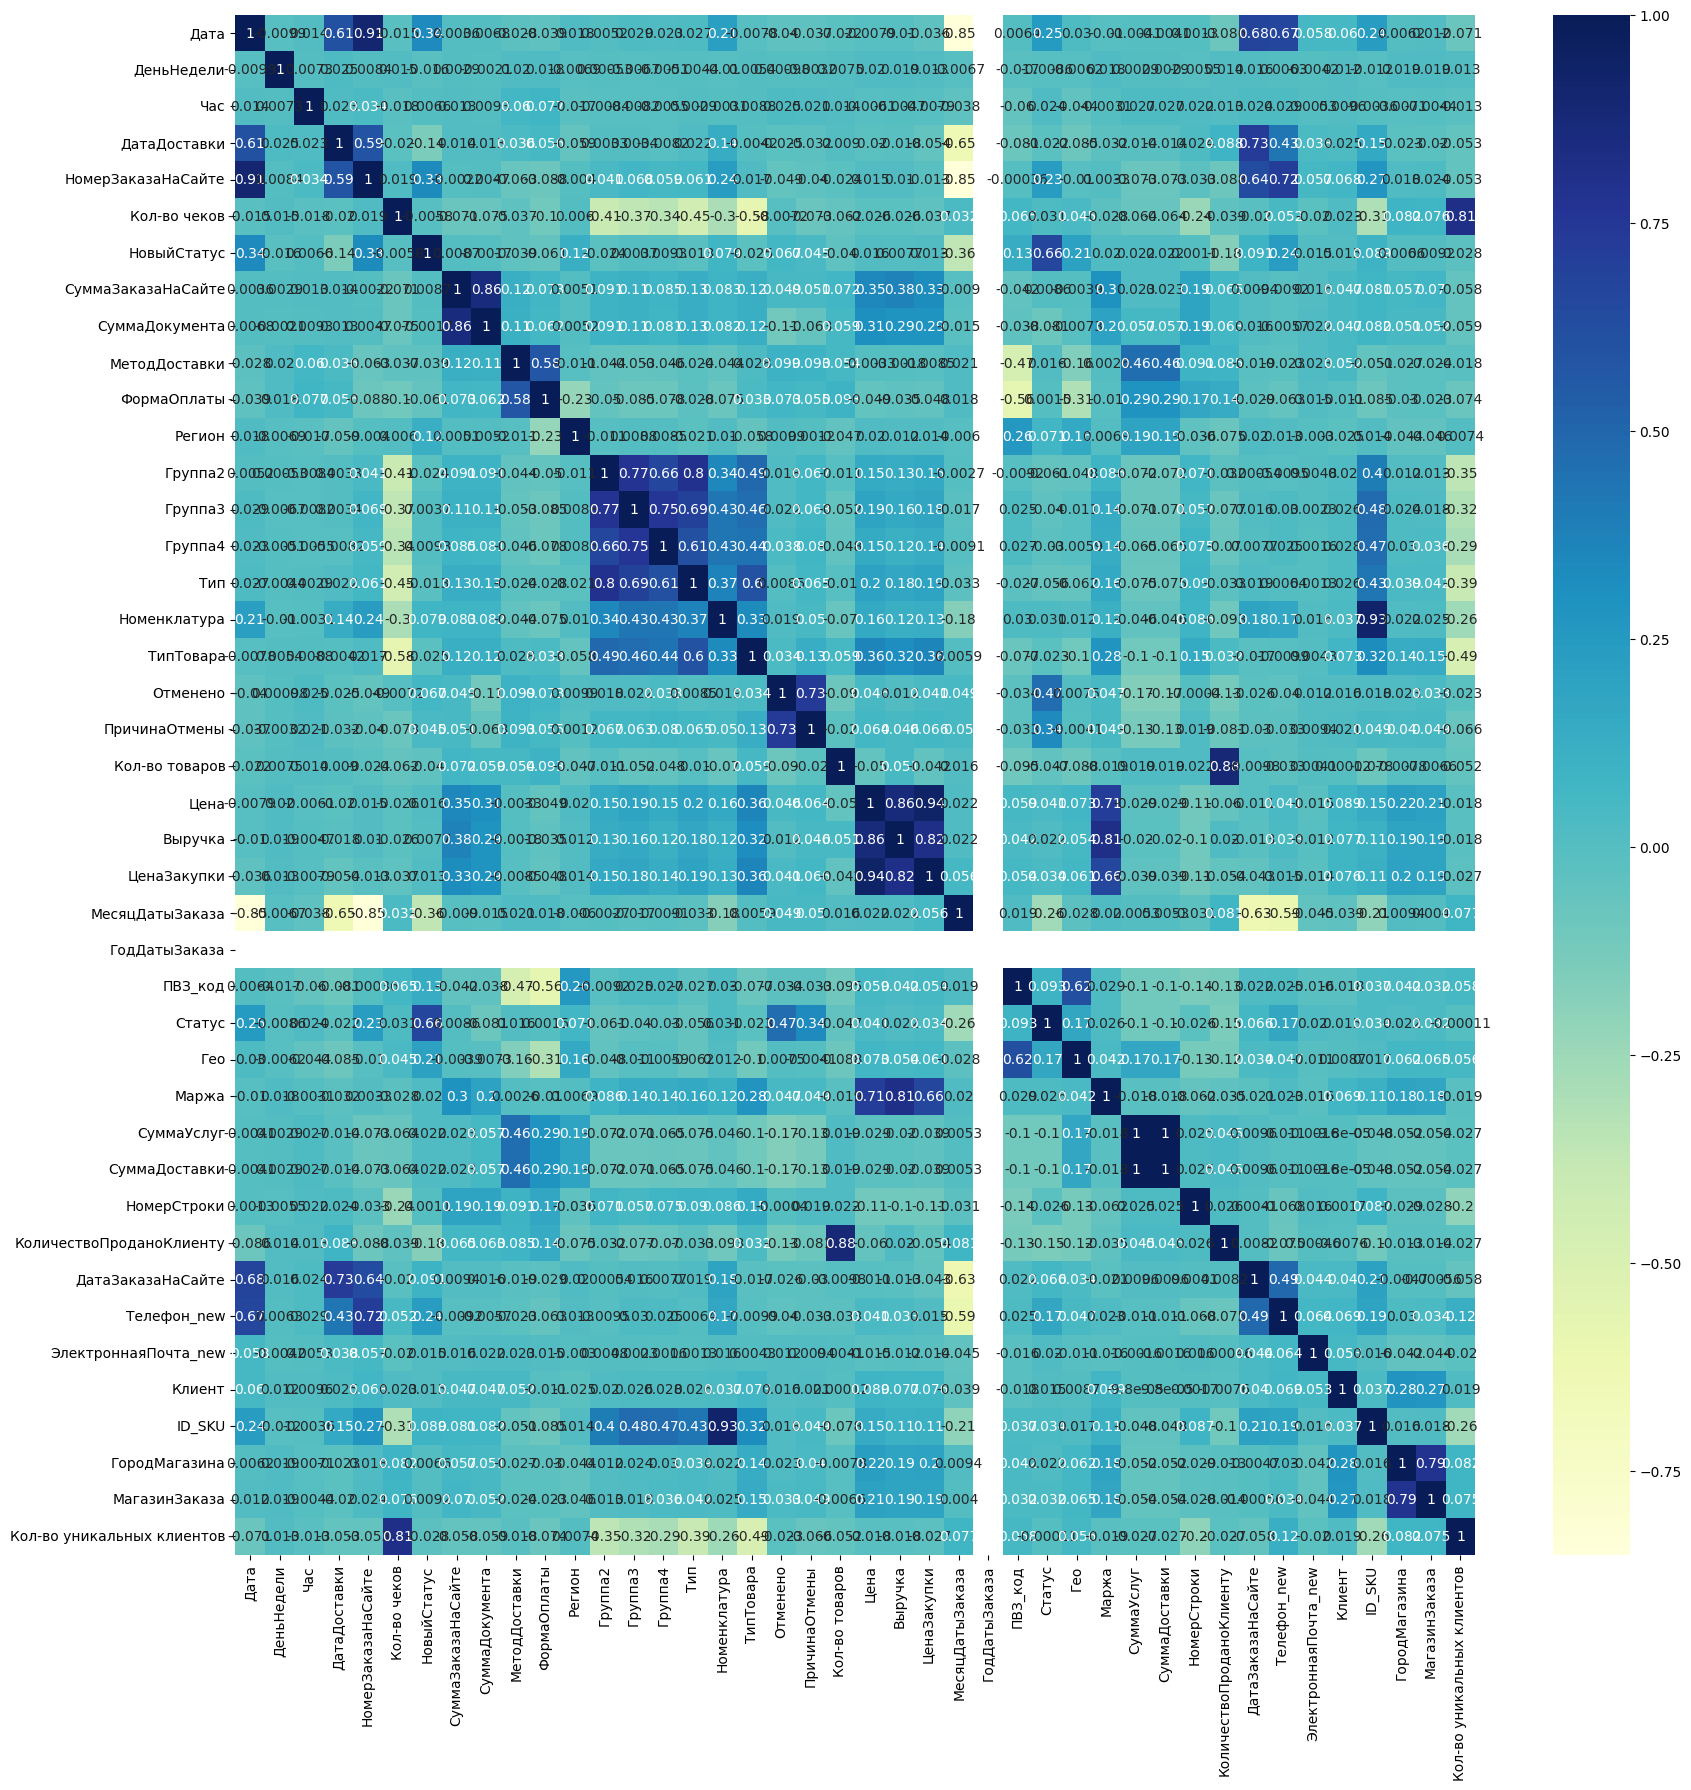

In [7]:
import seaborn as sns

# Создаем фигуру и оси для построения тепловой карты
fig, ax = plt.subplots(figsize=(20, 20))

# Создаем тепловую карту корреляции для DataFrame df
# cmap="YlGnBu" задает цветовую палитру для отображения корреляций
# annot=True включает отображение численных значений корреляций на тепловой карте
# ax=ax указывает, что тепловая карта будет нарисована на определенных осях
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, ax=ax)

# Показываем тепловую карту
plt.show()

In [8]:
# Вычисляем матрицу корреляции для DataFrame df
corr_matrix = df.corr()

# Используем np.triu для получения верхнего треугольника матрицы корреляции
# k=1 указывает, что мы исключаем главную диагональ
upper_tri = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(bool))

# Находим столбцы, в которых корреляция больше порога (в данном случае 0.80)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]

# Добавляем дополнительные столбцы, которые необходимо удалить
to_drop += ["Номенклатура", "Телефон_new", "ЭлектроннаяПочта_new", "МагазинЗаказа", "МагазинЗаказа", "ПричинаОтмены", "ПВЗ_код", \
            "Клиент", "ID_SKU", "ГодДатыЗаказа", "Кол-во чеков", "НомерЗаказаНаСайте", "Кол-во уникальных клиентов", "СуммаЗаказаНаСайте", \
            "СуммаДокумента", "Дата", "ДатаДоставки", "КоличествоПроданоКлиенту", "ДатаЗаказаНаСайте", "НомерСтроки"]

# Используем set для удаления повторяющихся столбцов
to_drop = list(set(to_drop))

# Удаляем коррелирующие столбцы и столбцы, которые не несут полезной информации
df = df.drop(to_drop, axis=1)

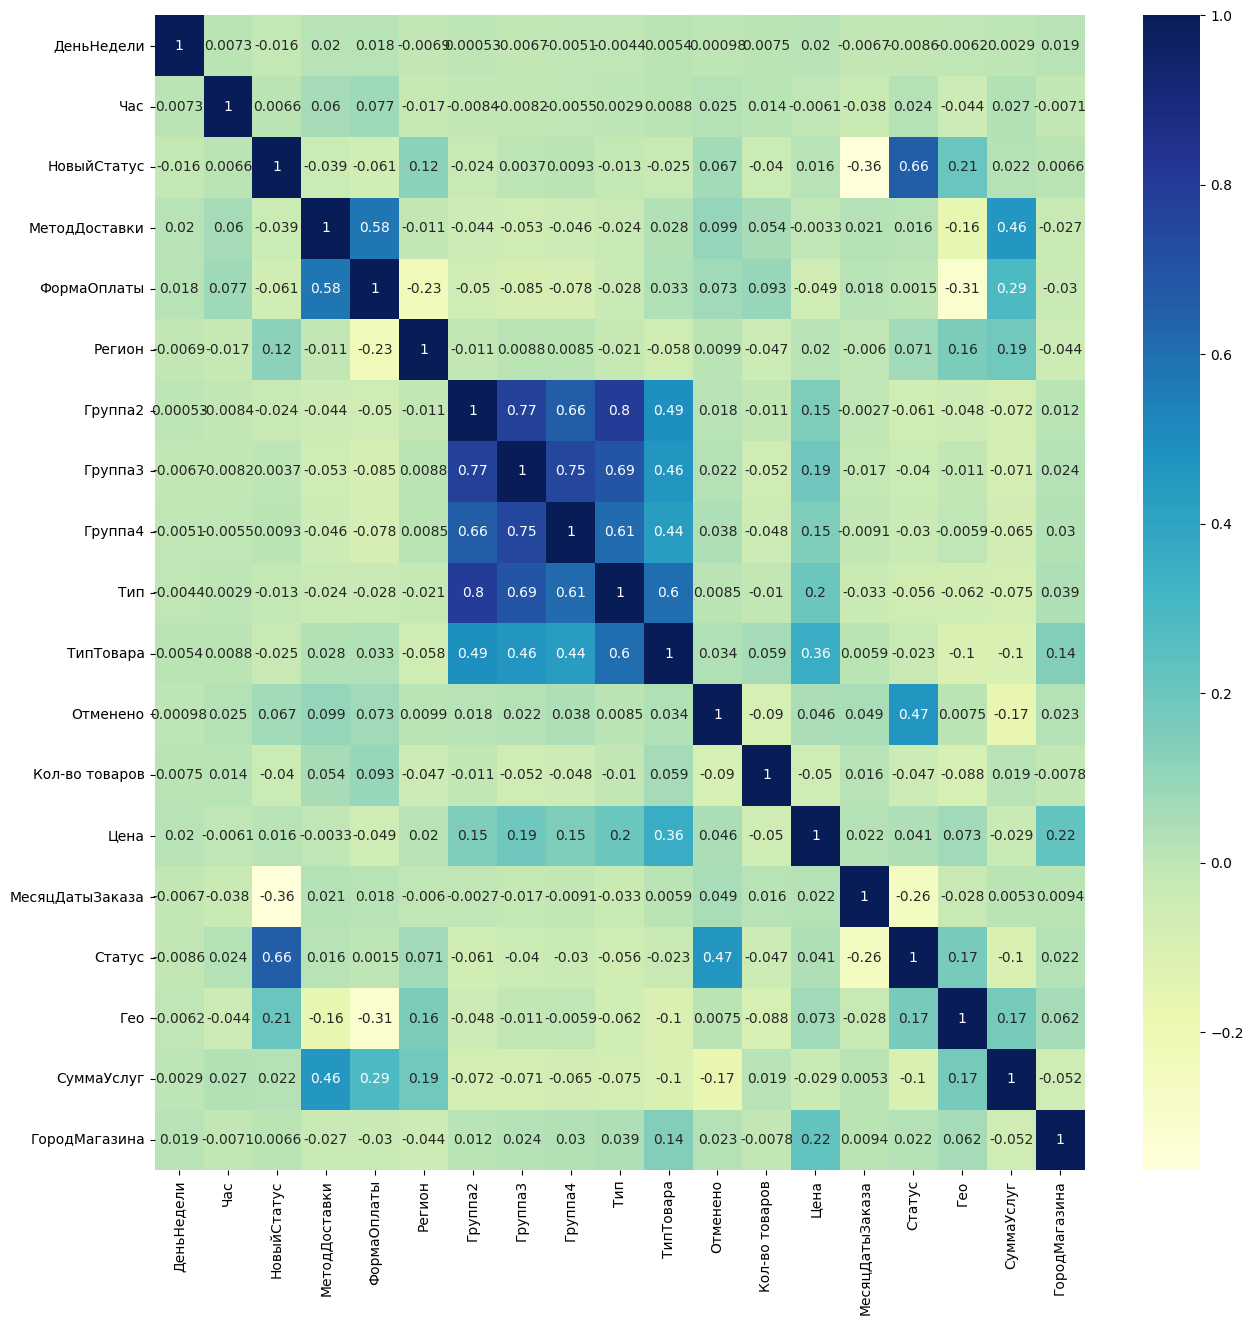

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))    
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, ax=ax)
plt.show()

In [10]:
from tqdm import tqdm  # Импорт прогресс-бара tqdm
from scipy.spatial.distance import cdist  # Импорт функции cdist для вычисления матрицы попарных расстояний
from collections import defaultdict  # Импорт класса defaultdict для создания словаря с значениями по умолчанию

SEED = 42  # Задаем значение для генератора случайных чисел
outliers = IsolationForest(random_state=SEED).fit_predict(df.values)  # Обнаружение выбросов с помощью модели Isolation Forest
df = df[outliers == 1]  # Фильтрация DataFrame, оставляя только не-выбросы

features = StandardScaler().fit_transform(df)  # Нормализация данных с помощью StandardScaler (стандартизация: (x - mean) / std)
features = PCA(n_components=2, random_state=SEED).fit_transform(features)  # Применение метода главных компонент (PCA) для снижения размерности данных до 2 компонент

In [11]:
result = defaultdict(list)  # Создание словаря с пустыми списками в качестве значений по умолчанию

# Цикл для значения n от 1 до 12 с отображением прогресс-бара
for n in tqdm(range(1, 13), leave=False):
    kmeanModel = KMeans(n, n_init=10).fit(features)  # Создание и обучение модели KMeans с указанным количеством кластеров
    distances = np.min(cdist(features, kmeanModel.cluster_centers_), axis=1)  # Вычисление минимальных расстояний от каждой точки до центров кластеров
    mean_distance = np.mean(distances)  # Вычисление среднего значения минимальных расстояний
    result['distance'].append(mean_distance)  # Добавление среднего значения в список distance в словаре result

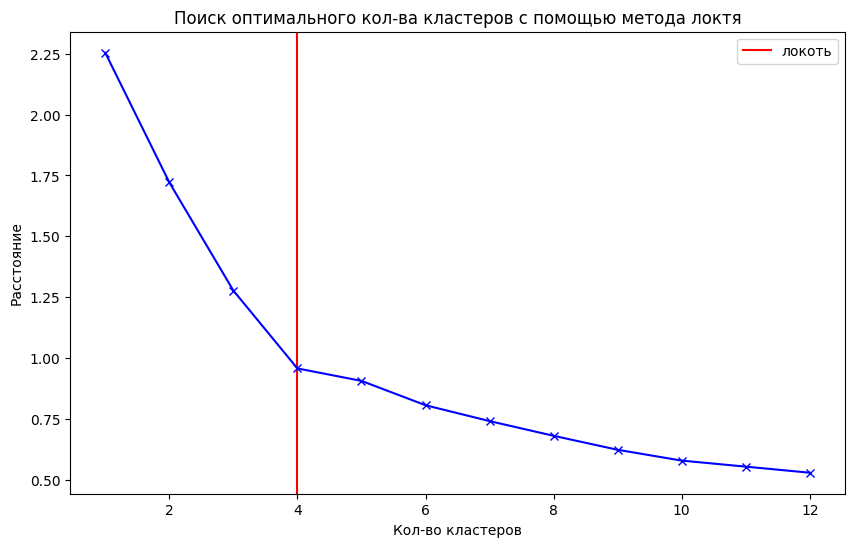

In [12]:
cl_range = range(1, 13)  # Диапазон значений количества кластеров от 1 до 12

plt.figure(figsize=(10, 6))  # Создание фигуры для графика с указанным размером

plt.axvline(4, 0, 1, label='локоть', color='red')  # Вертикальная линия, обозначающая "локоть" на графике

plt.plot(cl_range, result['distance'], 'bx-')  # Построение графика с количеством кластеров по оси x и значениями расстояний по оси y

plt.xlabel('Кол-во кластеров')  # Наименование оси x
plt.ylabel('Расстояние')  # Наименование оси y
plt.title('Поиск оптимального кол-ва кластеров с помощью метода локтя')  # Заголовок графика

plt.legend()  # Вывод легенды
plt.show()  # Отображение графика


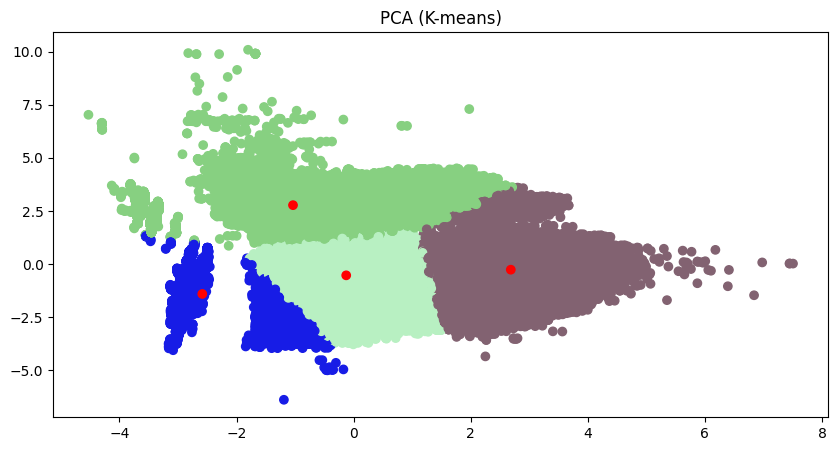

In [12]:
n_clusters = 4  # Количество кластеров, которые будут образованы (по методу локтя)

kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(features)  # Применение алгоритма K-means с указанным количеством кластеров к данным features
kmeans_pca = kmeans.predict(features)  # Получение предсказанных меток кластеров для каждой точки данных features

colors = np.sqrt(np.random.randint(0, 255, size=(n_clusters, 3))/255)  # Генерация случайных цветов для каждого кластера

c_arr = np.array(list(map(lambda x: colors[x], list(kmeans_pca))))  # Преобразование меток кластеров в цвета для каждой точки данных

plt.figure(figsize=(10,5))  # Создание фигуры для графика с указанным размером

plt.title('PCA (K-means)')  # Заголовок графика

plt.scatter(features[:, 0], features[:, 1], c=c_arr)  # Построение точечного графика, где по оси x отображается первая главная компонента, по оси y - вторая. Цвет точек соответствует их кластеру, заданным в переменной c_arr.

c_arr = np.array([[1, 0, 0] for i in range(n_clusters)])  # Создание массива цветов для центров кластеров (в данном случае, красный цвет [1, 0, 0])

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c=c_arr)  # Построение точечного графика для центров кластеров. Цвет точек задан в переменной c_arr.


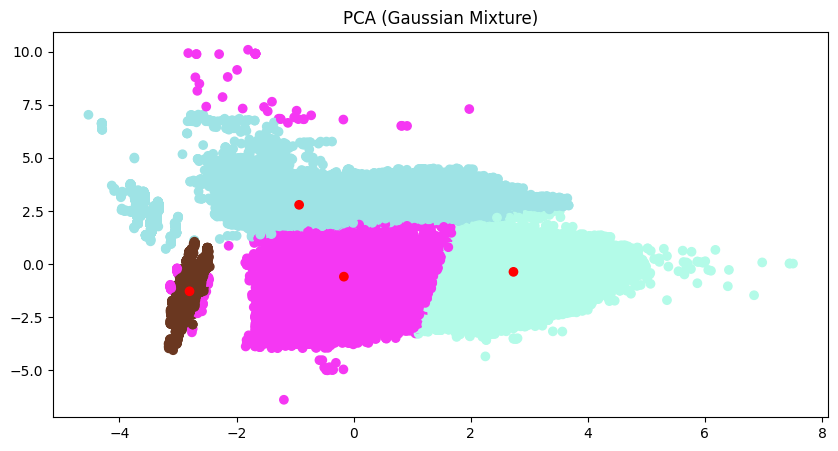

In [14]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=n_clusters, random_state=SEED).fit(features)  # Применение модели Gaussian Mixture с указанным количеством кластеров к данным features
labels = gm.predict(features)  # Получение предсказанных меток кластеров для каждой точки данных features

colors = np.sqrt(np.random.randint(0, 255, size=(n_clusters, 3))/255)  # Генерация случайных цветов для каждого кластера

c_arr = np.array(list(map(lambda x: colors[x], list(labels))))  # Преобразование меток кластеров в цвета для каждой точки данных

plt.figure(figsize=(10,5))  # Создание фигуры для графика с указанным размером

plt.title('PCA (Gaussian Mixture)')  # Заголовок графика

plt.scatter(features[:, 0], features[:, 1], c=c_arr)  # Построение точечного графика, где по оси x отображается первая главная компонента, по оси y - вторая. Цвет точек соответствует их кластеру, заданным в переменной c_arr.

c_arr = np.array([[1, 0, 0] for i in range(n_clusters)])  # Создание массива цветов для центров кластеров (в данном случае, красный цвет [1, 0, 0])

plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c=c_arr)  # Построение точечного графика для центров кластеров. Цвет точек задан в переменной c_arr.


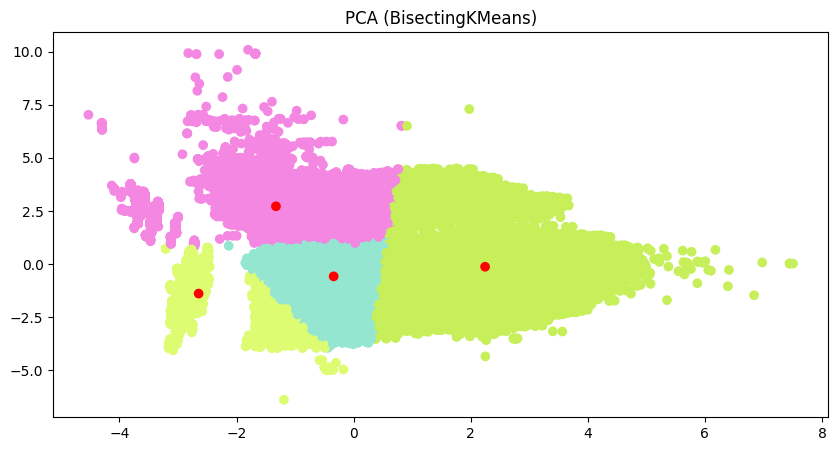

In [15]:
from sklearn.cluster import BisectingKMeans

bkmeans = BisectingKMeans(n_clusters=n_clusters)  # Создаем объект Bisecting K-means с указанным количеством кластеров
labels = bkmeans.fit_predict(features)  # Выполняем кластеризацию данных features и получаем метки кластеров
colors = np.sqrt(np.random.randint(0, 255, size=(n_clusters, 3))/255)  # Генерируем случайные цвета для визуализации кластеров
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(10,5))
plt.title('PCA (BisectingKMeans)')
plt.scatter(features[:, 0], features[:, 1], c=c_arr)  # Отображаем точки данных, окрашенные в соответствии с их кластерами
c_arr = np.array([[1, 0, 0] for i in range(n_clusters)])
plt.scatter(bkmeans.cluster_centers_.reshape(4, 2)[:, 0], bkmeans.cluster_centers_.reshape(4, 2)[:, 1], c=c_arr)  # Отображаем центры кластеров

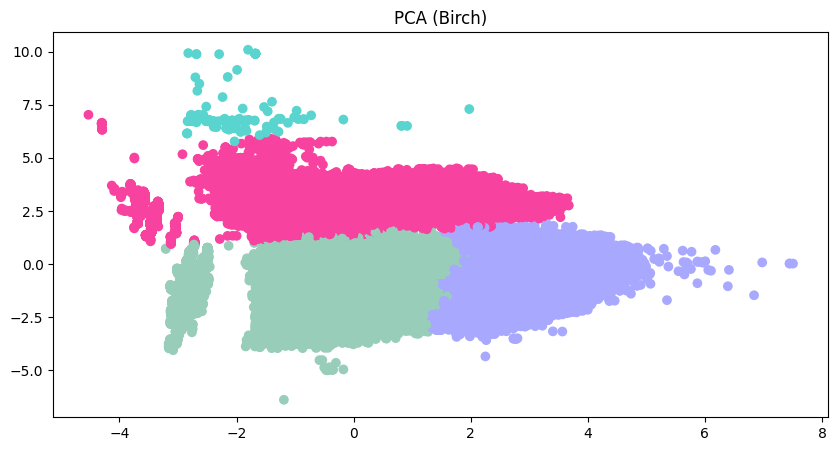

In [16]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=n_clusters)  # Создаем объект Birch с указанным количеством кластеров
labels = birch.fit_predict(features)  # Выполняем кластеризацию данных features и получаем метки кластеров
colors = np.sqrt(np.random.randint(0, 255, size=(n_clusters, 3))/255)  # Генерируем случайные цвета для визуализации кластеров
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(10,5))
plt.title('PCA (Birch)')
plt.scatter(features[:, 0], features[:, 1], c=c_arr)  # Отображаем точки данных, окрашенные в соответствии с их кластерами
c_arr = np.array([[1, 0, 0] for i in range(n_clusters)])

In [ ]:
from fcmeans import FCM

fcm = FCM(n_clusters=n_clusters)  # Создаем объект FCM с указанным количеством кластеров
fcm.fit(features)  # Выполняем кластеризацию данных features с использованием FCM

fcm_centers = fcm.centers  # Получаем координаты центров кластеров
fcm_labels = fcm.predict(features)  # Получаем метки кластеров для каждой точки данных

# Визуализация результатов
plt.figure(figsize=(10,5))
plt.scatter(features[:, 0], features[:, 1], c=fcm_labels, alpha=.1)  # Отображаем точки данных, окрашенные в соответствии с их кластерами
plt.scatter(fcm_centers[:, 0], fcm_centers[:, 1], marker="+", s=500, c='r')  # Отображаем центры кластеров
plt.title('PCA (CMeans)')
plt.show()

In [ ]:
from sklearn.cluster import OPTICS

labels = OPTICS().fit_predict(features)

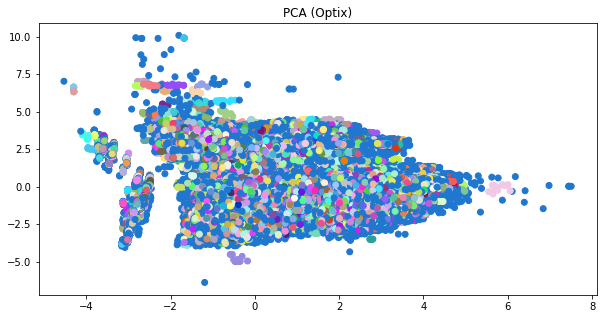

In [17]:
colors = np.sqrt(np.random.randint(0, 255, size=(len(set(labels)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(labels))))

plt.figure(figsize=(10,5))
plt.title('PCA (Optix)')
plt.scatter(features[:, 0], features[:, 1], c=c_arr)  # кластеризация Kmeans
#c_arr = np.array([[1, 0, 0] for i in range(n_clusters)])
#plt.scatter(bkmeans.cluster_centers_.reshape(4, 2)[:, 0], bkmeans.cluster_centers_.reshape(4, 2)[:, 1], c=c_arr)  # покажем центры кластеров

In [19]:
silhouette_score(features, labels)

0.005928762046657749

In [20]:
davies_bouldin_score(features, labels)

1.8292120322876249

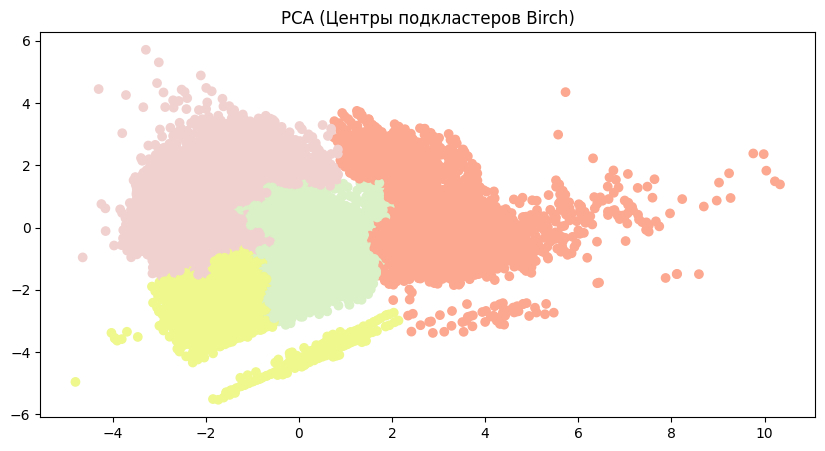

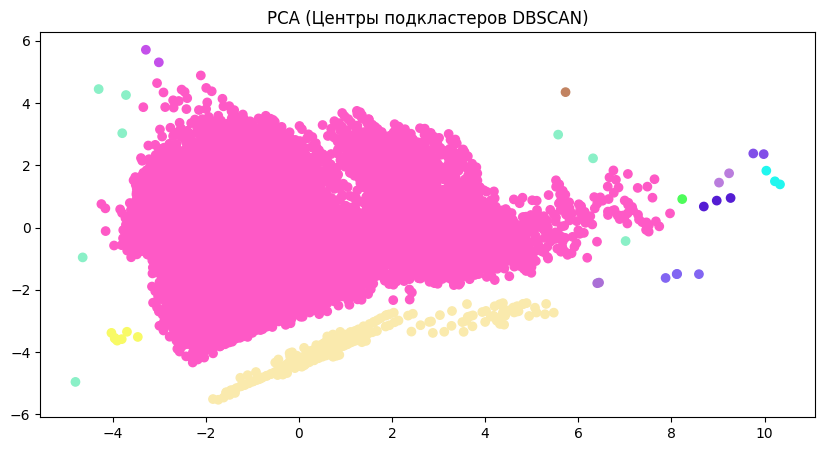

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import Birch, DBSCAN
from sklearn.decomposition import PCA

min_pts, eps, delta = 50, 0.5, 0.1

# Кластеризация методом Birch
birch = Birch(threshold=eps * delta, branching_factor=min_pts, n_clusters=4)
birch_labels = birch.fit_predict(features)

# Применение PCA к центрам подкластеров Birch
pca = PCA(n_components=2)
birch_centers_pca = pca.fit_transform(birch.subcluster_centers_)

# Визуализация центров подкластеров Birch с использованием PCA
colors = np.sqrt(np.random.randint(0, 255, size=(len(set(birch.subcluster_labels_)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(birch.subcluster_labels_))))
plt.figure(figsize=(10, 5))
plt.title('PCA (Центры подкластеров Birch)')
plt.scatter(birch_centers_pca[:, 0], birch_centers_pca[:, 1], c=c_arr)

# Кластеризация методом DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_pts, metric="euclidean").fit(birch.subcluster_centers_, sample_weight=birch._subcluster_norms)

# Применение PCA к центрам подкластеров DBSCAN
dbscan_centers_pca = pca.transform(birch.subcluster_centers_)

# Визуализация центров подкластеров DBSCAN с использованием PCA
colors = np.sqrt(np.random.randint(0, 255, size=(len(set(dbscan.labels_)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(dbscan.labels_))))
plt.figure(figsize=(10, 5))
plt.title('PCA (Центры подкластеров DBSCAN)')
plt.scatter(dbscan_centers_pca[:, 0], dbscan_centers_pca[:, 1], c=c_arr)


Сначала мы применяем метод Birch для кластеризации данных. Мы создаем объект Birch с параметрами threshold, branching_factor и n_clusters. Параметр threshold задает пороговое значение для расстояния между точками, чтобы определить, является ли точка центром подкластера. Параметр branching_factor определяет максимальное количество дочерних узлов в дереве Birch, а n_clusters указывает желаемое количество кластеров. Затем мы применяем метод fit_predict к объекту Birch и сохраняем метки кластеров в переменную birch_labels.

Далее мы создаем цвета для визуализации подкластерных центров Birch с помощью случайных значений RGB. Затем мы строим график, используя функцию scatter, где x-координаты представлены первой компонентой PCA подкластерных центров, а y-координаты - второй компонентой PCA. Цвета точек соответствуют меткам подкластеров.

После этого мы применяем метод DBSCAN к подкластерным центрам Birch. Создаем объект DBSCAN с параметрами eps (радиус окрестности) и min_samples (минимальное количество точек в окрестности). Мы применяем метод fit к подкластерным центрам Birch и сохраняем метки кластеров в переменную dbscan.labels_.

In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

idx = np.random.choice(np.arange(features.shape[0]), 100000, replace=False)

# KMeans
kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(features)
kmeans_pca = kmeans.predict(features[idx])
silhouette_kmeans = silhouette_score(features[idx], kmeans_pca)
db_kmeans = davies_bouldin_score(features[idx], kmeans_pca)
print(f"KMeans:\nSilhouette Score: {silhouette_kmeans}\nDavies-Bouldin Score: {db_kmeans}")

# Gaussian Mixture
gm = GaussianMixture(n_components=n_clusters, random_state=SEED).fit(features)
gm_labels = gm.predict(features[idx])
silhouette_gm = silhouette_score(features[idx], gm_labels)
db_gm = davies_bouldin_score(features[idx], gm_labels)
print(f"Gaussian Mixture:\nSilhouette Score: {silhouette_gm}\nDavies-Bouldin Score: {db_gm}")

# Bisecting KMeans
bkmeans = BisectingKMeans(n_clusters=n_clusters)
bkmeans_labels = bkmeans.fit_predict(features)
silhouette_bkmeans = silhouette_score(features[idx], bkmeans_labels[idx])
db_bkmeans = davies_bouldin_score(features[idx], bkmeans_labels[idx])
print(f"Bisecting KMeans:\nSilhouette Score: {silhouette_bkmeans}\nDavies-Bouldin Score: {db_bkmeans}")

# Birch
birch = Birch(n_clusters=n_clusters)
birch_labels = birch.fit_predict(features)
silhouette_birch = silhouette_score(features[idx], birch_labels[idx])
db_birch = davies_bouldin_score(features[idx], birch_labels[idx])
print(f"Birch:\nSilhouette Score: {silhouette_birch}\nDavies-Bouldin Score: {db_birch}")

# Birch-DBSCAN hybrid
min_pts, eps, delta = 50, 0.5, 0.1
birch = Birch(threshold=eps * delta, branching_factor=min_pts, n_clusters=4)
birch_labels = birch.fit_predict(features)
silhouette_birch_dbscan = silhouette_score(features[idx], birch_labels[idx])
db_birch_dbscan = davies_bouldin_score(features[idx], birch_labels[idx])
print(f"Birch-DBSCAN Hybrid:\nSilhouette Score: {silhouette_birch_dbscan}\nDavies-Bouldin Score: {db_birch_dbscan}")

KMeans:
Silhouette Score: 0.517127342610982
Davies-Bouldin Score: 0.6512971666868171
Gaussian Mixture:
Silhouette Score: 0.5164683620655401
Davies-Bouldin Score: 0.637548574699173
Bisecting KMeans:
Silhouette Score: 0.46286705200005474
Davies-Bouldin Score: 0.7071892714462453
Birch:
Silhouette Score: 0.483499021987589
Davies-Bouldin Score: 0.6374756243348135
Birch-DBSCAN Hybrid:
Silhouette Score: 0.43616997073067476
Davies-Bouldin Score: 0.8128792495830266


In [145]:
idx = np.random.choice(np.arange(features.shape[0]), 100000, replace=False)  # берем подвыбрку из 100к векторов
silhouette = silhouette_score(features[idx], fcm_labels[idx])
db = davies_bouldin_score(features[idx], fcm_labels[idx])
print(f"C Means : \n silhouette: {silhouette} db: {db}")

C Means : 
 silhouette: 0.46949208579032625 db: 0.781858267378695


Интерпретация результатов:

KMeans:

Silhouette Score: 0.518
Davies-Bouldin Score: 0.652
KMeans показал средний уровень разделения между кластерами с некоторым перекрытием их областей, что отражается в сравнительно высоком значении Silhouette Score. Davies-Bouldin Score также указывает на разделение кластеров с некоторой степенью перекрывания, но с умеренным значением.
Gaussian Mixture:

Silhouette Score: 0.517
Davies-Bouldin Score: 0.638
Gaussian Mixture также показал средний уровень разделения между кластерами с некоторым перекрытием областей. Значения Silhouette Score и Davies-Bouldin Score подтверждают это.
Bisecting KMeans:

Silhouette Score: 0.476
Davies-Bouldin Score: 0.697
Bisecting KMeans имеет ниже средние значения Silhouette Score и Davies-Bouldin Score, что указывает на более слабое разделение кластеров и некоторое перекрытие их областей.
Birch:

Silhouette Score: 0.484
Davies-Bouldin Score: 0.651
Birch также показывает средний уровень разделения кластеров с некоторым перекрытием областей, подтверждаемый значениями Silhouette Score и Davies-Bouldin Score.
Birch-DBSCAN Hybrid:

Silhouette Score: 0.437
Davies-Bouldin Score: 0.809
Гибридный метод, объединяющий Birch и DBSCAN, показывает наихудшие результаты в сравнении с другими методами. Низкие значения Silhouette Score и высокий Davies-Bouldin Score указывают на слабое разделение и перекрытие кластеров.
C Means:

Silhouette Score: 0.469
Davies-Bouldin Score: 0.782
C Means показывает средний уровень разделения между кластерами с некоторым перекрытием областей, сопоставимым с результатами Bisecting KMeans.
Общий вывод:
На основе Silhouette Score и Davies-Bouldin Score можно сказать, что KMeans и Gaussian Mixture показывают схожие результаты с наилучшим разделением и меньшим перекрытием кластеров, в то время как Bisecting KMeans и Birch имеют средние результаты. Гибридный метод Birch-DBSCAN показывает наихудшие результаты с наименьшим разделением и наибольшим перекрытием кластеров.


Гибридный метод Birch-DBSCAN может показывать более низкое качество разделения кластеров по сравнению с методом Birch по нескольким причинам:

Вариация параметров: Гибридный метод требует настройки параметров для обоих методов - Birch и DBSCAN. Неправильный выбор параметров может привести к неправильному разделению кластеров или перекрытию областей, что отрицательно сказывается на метриках качества.

Различные принципы работы: Birch и DBSCAN имеют различные принципы работы. Birch стремится строить иерархическую структуру подкластеров на основе плотности данных, в то время как DBSCAN идентифицирует области высокой плотности в пространстве признаков. Их комбинация в гибридном методе может привести к сложностям в определении оптимальной границы и областей разделения кластеров.

Чувствительность к параметрам: DBSCAN требует настройки параметров eps (радиус окрестности) и min_samples (минимальное количество точек в окрестности), которые влияют на процесс кластеризации. Неправильный выбор этих параметров может привести к недостаточной или избыточной кластеризации. Гибридный метод должен учитывать и согласовывать параметры обоих методов для достижения оптимального разделения.

Шум и выбросы: DBSCAN может быть более чувствителен к выбросам и шуму в данных. Если в данных присутствуют значительные выбросы или шум, DBSCAN может иметь трудности с определением правильных кластеров и может создавать неправильные подкластеры, что отрицательно сказывается на качестве разделения.

Все эти факторы могут привести к ухудшению качества разделения кластеров в гибридном методе Birch-DBSCAN по сравнению с простым методом Birch. Точная настройка параметров и понимание принципов работы обоих методов могут помочь улучшить результаты гибридного подхода.